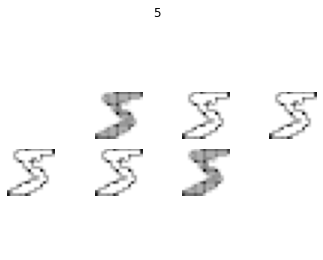

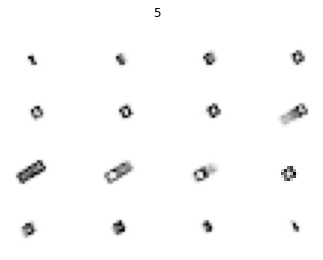

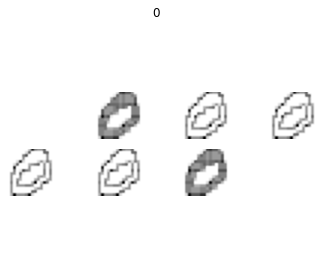

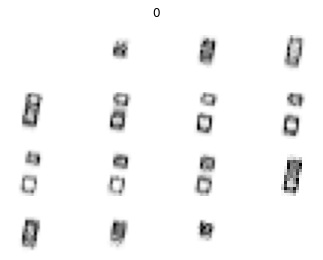

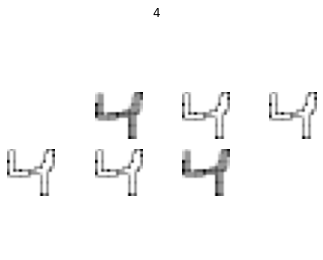

In [1]:
import h5py
import os
import matplotlib.pyplot as plt
import numpy as np

data_path = os.path.join(os.path.expanduser('~'), 'data', '3d-mnist', 
                         'full_dataset_vectors.h5')

assert os.path.isfile(data_path), \
    'Download the 3d-mnist data from https://www.kaggle.com/daavoo/3d-mnist'

with h5py.File(data_path, 'r') as f:
    train_X = np.reshape(f["X_train"][:], (-1, 16, 16, 16, 1))
    train_y = f["y_train"][:]    
    test_X = np.reshape(f["X_test"][:]  , (-1, 16, 16, 16, 1))
    test_y = f["y_test"][:]

train_X = train_X[:,::-1,:,:]
test_X = test_X[:,::-1,:,:]

def onehot(values: np.ndarray) -> np.ndarray:
    encoded = np.zeros((len(values), 10))

    for i in range(len(values)):
        encoded[i,values[i]] = 1

    return encoded

train_y = onehot(train_y)
test_y = onehot(test_y)

for i in range(5):
    fig, ax = plt.subplots(4, 4)
    fig.suptitle(str(np.argmax(train_y[i])))
    ax = ax.ravel()

    for j in range(16):
        ax[j].imshow(train_X[i,:,:,j], cmap='Greys')
        ax[j].axis('off')

    plt.show()

In [2]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Activation, BatchNormalization, Conv3D, Dense, \
                                    Dropout, Flatten, \
                                    GlobalAveragePooling3D, Input, \
                                    MaxPooling3D
from tensorflow.keras.regularizers import l2

inputs = Input((16, 16, 16, 1), name='inputs')

x = inputs

kernel = (3, 3, 3)
dropout = 0.3
weight_decay = 1e-3
regularizer = l2(weight_decay)

x = Conv3D(32, kernel, padding='SAME', activation=None, 
           kernel_regularizer=regularizer, name='conv1')(x)
x = BatchNormalization(name='norm1')(x)
x = Activation('relu')(x)
x = Conv3D(32, kernel, padding='SAME', activation=None, 
           kernel_regularizer=regularizer, name='conv2')(x)
x = BatchNormalization(name='norm2')(x)
x = Activation('relu')(x)
x = MaxPooling3D((2, 2, 2), name='pool1')(x)
x = Conv3D(64, kernel, padding='SAME', activation=None, 
           kernel_regularizer=regularizer, name='conv3')(x)
x = BatchNormalization(name='norm3')(x)
x = Activation('relu')(x)
x = Conv3D(64, kernel, padding='SAME', activation=None, 
           kernel_regularizer=regularizer, name='conv4')(x)
x = BatchNormalization(name='norm4')(x)
x = Activation('relu')(x)
x = MaxPooling3D((2, 2, 2), name='pool2')(x)
x = Conv3D(128, kernel, padding='SAME', activation=None, 
           kernel_regularizer=regularizer, name='conv5')(x)
x = BatchNormalization(name='norm5')(x)
x = Activation('relu')(x)
x = Conv3D(128, kernel, padding='SAME', activation=None, 
           kernel_regularizer=regularizer, name='conv6')(x)
x = BatchNormalization(name='norm6')(x)
x = MaxPooling3D((2, 2, 2), name='pool3')(x)
x = Conv3D(256, kernel, padding='SAME', activation=None, 
           kernel_regularizer=regularizer, name='conv7')(x)
x = BatchNormalization(name='norm7')(x)
x = Activation('relu')(x)
x = Conv3D(256, kernel, padding='SAME', activation=None, 
           kernel_regularizer=regularizer, name='conv8')(x)
x = BatchNormalization(name='norm8')(x)
x = Activation('relu')(x)
x = GlobalAveragePooling3D(name='pool4')(x)
x = Dropout(dropout)(x)
x = Dense(10, kernel_regularizer=regularizer, activation=None, name='dense')(x)
x = BatchNormalization(name='norm9')(x)
x = Activation('relu')(x)
x = Dropout(dropout)(x)
x = Dense(10, activation='softmax', name='preds')(x)

model = Model(inputs, x)
model.summary()


2022-03-13 11:28:52.233368: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-13 11:28:52.239357: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-13 11:28:52.239528: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 16, 16, 16, 1)]   0         
_________________________________________________________________
conv1 (Conv3D)               (None, 16, 16, 16, 32)    896       
_________________________________________________________________
norm1 (BatchNormalization)   (None, 16, 16, 16, 32)    128       
_________________________________________________________________
activation (Activation)      (None, 16, 16, 16, 32)    0         
_________________________________________________________________
conv2 (Conv3D)               (None, 16, 16, 16, 32)    27680     
_________________________________________________________________
norm2 (BatchNormalization)   (None, 16, 16, 16, 32)    128       
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 16, 32)    0     

2022-03-13 11:28:52.240463: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-13 11:28:52.241043: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-13 11:28:52.241240: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-13 11:28:52.241373: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [3]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

model.compile(loss='categorical_crossentropy', optimizer=Adam(1e-3),
              metrics=['accuracy'])

callbacks = [
    ReduceLROnPlateau(
        monitor="loss",
        factor=0.1,
        patience=5,
        verbose=1
    )
]

model.fit(train_X, train_y, 
          validation_data=(test_X, test_y), 
          epochs=100, 
          batch_size=32, 
          shuffle=True,
          callbacks=callbacks)

2022-03-13 11:28:53.325602: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-03-13 11:28:54.784579: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2022-03-13 11:28:54.975813: W tensorflow/stream_executor/gpu/asm_compiler.cc:113] *** WARNING *** You are using ptxas 9.1.108, which is older than 9.2.88. ptxas 9.x before 9.2.88 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You do not need to update to CUDA 9.2.88; cherry-picking the ptxas binary is sufficient.


313/313 [==============================] - 9s 22ms/step - loss: 2.5258 - accuracy: 0.2979 - val_loss: 2.5750 - val_accuracy: 0.1750
Epoch 2/100
313/313 [==============================] - 7s 21ms/step - loss: 1.9296 - accuracy: 0.4363 - val_loss: 1.7746 - val_accuracy: 0.5220
Epoch 3/100
313/313 [==============================] - 7s 21ms/step - loss: 1.7686 - accuracy: 0.4774 - val_loss: 1.5906 - val_accuracy: 0.5640
Epoch 4/100
313/313 [==============================] - 7s 21ms/step - loss: 1.6751 - accuracy: 0.5056 - val_loss: 1.7453 - val_accuracy: 0.4760
Epoch 5/100
313/313 [==============================] - 7s 21ms/step - loss: 1.6413 - accuracy: 0.5308 - val_loss: 1.3895 - val_accuracy: 0.6055
Epoch 6/100
313/313 [==============================] - 7s 21ms/step - loss: 1.5939 - accuracy: 0.5569 - val_loss: 1.6742 - val_accuracy: 0.5590
Epoch 7/100
313/313 [==============================] - 7s 22ms/step - loss: 1.5411 - accuracy: 0.5734 - val_loss: 1.4153 - val_accuracy: 0.6260
Epoc

313/313 [==============================] - 7s 23ms/step - loss: 0.4943 - accuracy: 0.9176 - val_loss: 1.0379 - val_accuracy: 0.8190
Epoch 58/100
313/313 [==============================] - 7s 22ms/step - loss: 0.4922 - accuracy: 0.9149 - val_loss: 1.0358 - val_accuracy: 0.8245
Epoch 59/100
313/313 [==============================] - 7s 22ms/step - loss: 0.4748 - accuracy: 0.9220 - val_loss: 1.0359 - val_accuracy: 0.8190
Epoch 60/100
313/313 [==============================] - 7s 23ms/step - loss: 0.4792 - accuracy: 0.9171 - val_loss: 1.0640 - val_accuracy: 0.8185
Epoch 61/100
313/313 [==============================] - 7s 23ms/step - loss: 0.4713 - accuracy: 0.9147 - val_loss: 1.0456 - val_accuracy: 0.8265
Epoch 62/100
313/313 [==============================] - 7s 23ms/step - loss: 0.4600 - accuracy: 0.9205 - val_loss: 1.0251 - val_accuracy: 0.8225
Epoch 63/100
313/313 [==============================] - 7s 23ms/step - loss: 0.4505 - accuracy: 0.9230 - val_loss: 1.0301 - val_accuracy: 0.824

In [16]:
from explainability import LayerwiseRelevancePropagator

image_idx = 0

explanations = np.zeros((10, 16, 16, 16, 1))
predictions = model.predict(train_X[image_idx:image_idx + 1])
print(f'Predictions: {predictions[0]}')

for i in range(10):
    explainer = LayerwiseRelevancePropagator(model, layer=33, idx=i, alpha=2, beta=1)
    explanations[i] = explainer(train_X[image_idx:image_idx + 1])
    print(f'Sum evidence for {i}: {np.sum(explanations[i])}')

Predictions: [2.24270957e-09 7.00051217e-08 2.81286368e-04 3.12355260e-04
 1.17062456e-07 9.99366701e-01 3.01169748e-05 5.58828290e-08
 1.06051168e-08 9.33957745e-06]
Sum evidence for 0: -13.465404039906389
Sum evidence for 1: -9.90697855874896
Sum evidence for 2: -1.2541746495626285
Sum evidence for 3: -1.1522016259550583
Sum evidence for 4: -9.272643872907793
Sum evidence for 5: 14.495859168469906
Sum evidence for 6: -3.5338118520448916
Sum evidence for 7: -10.142548436531797
Sum evidence for 8: -12.029681618485483
Sum evidence for 9: -4.778173037717352


In [13]:
model.save_weights('/home/esten/tmp_weights.hdf5')

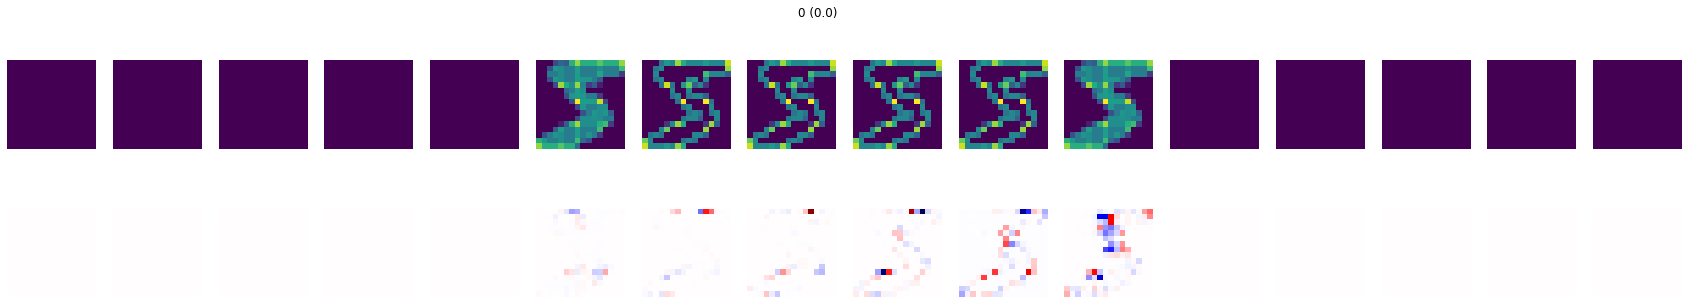

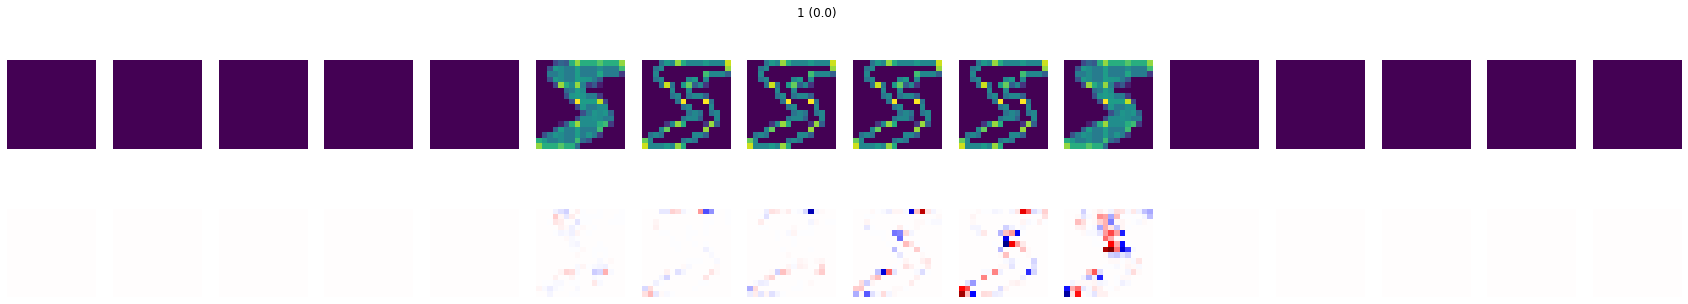

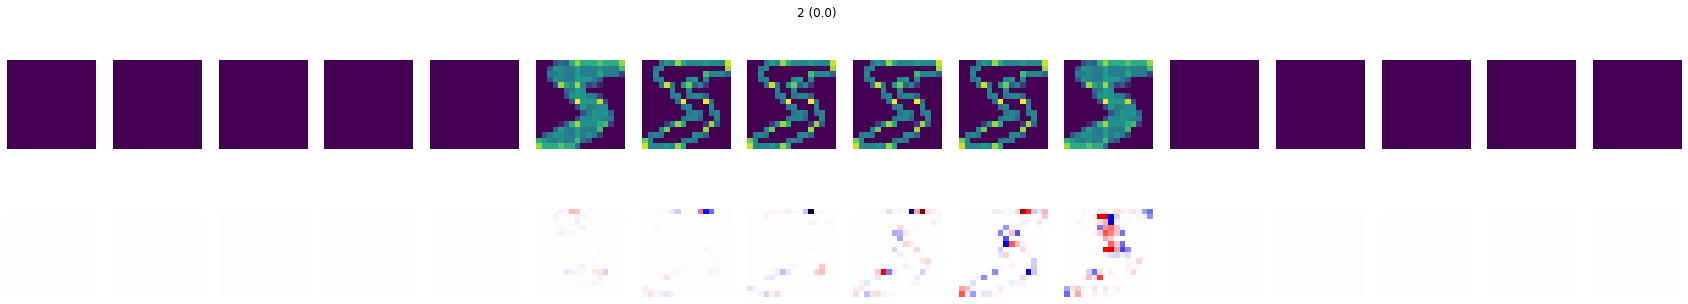

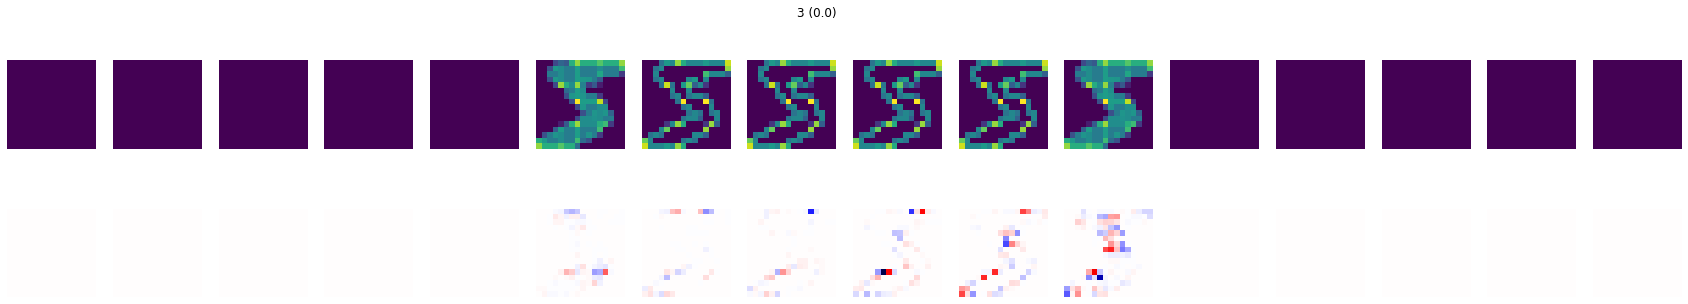

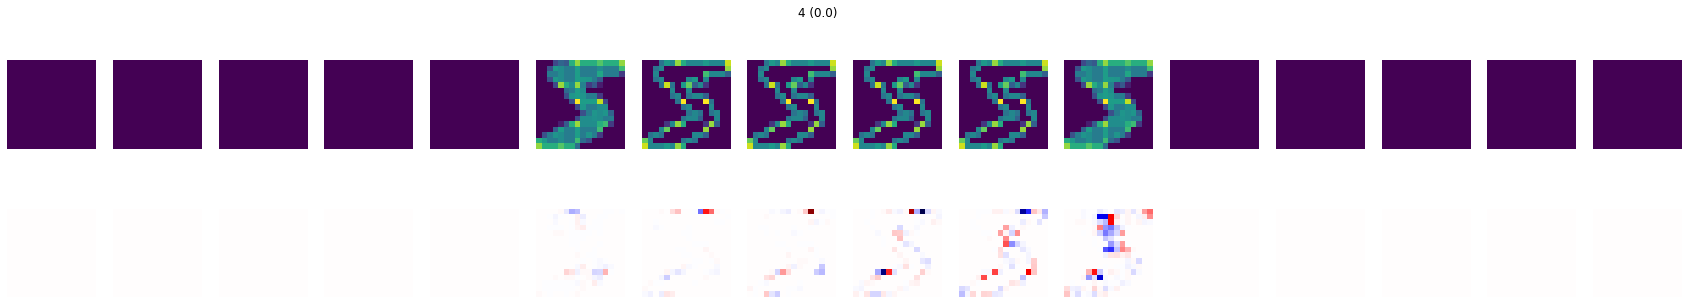

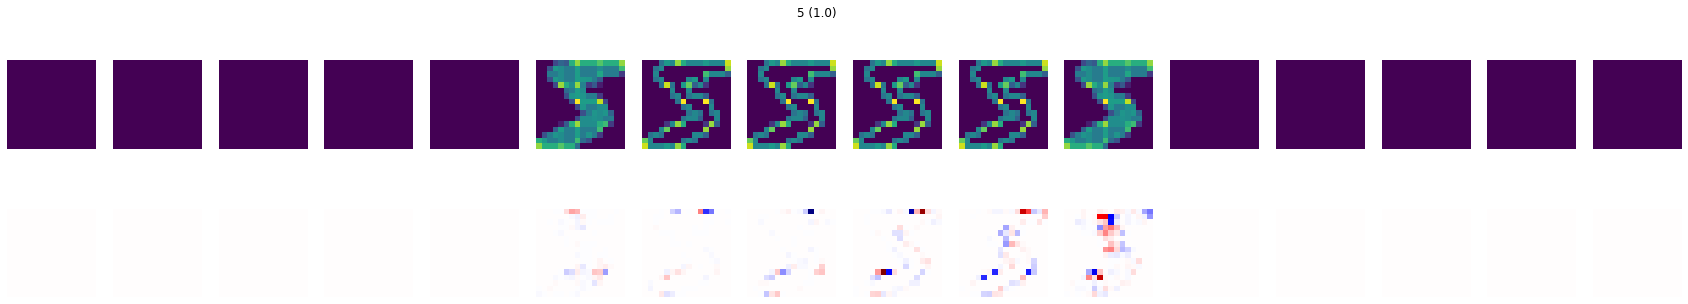

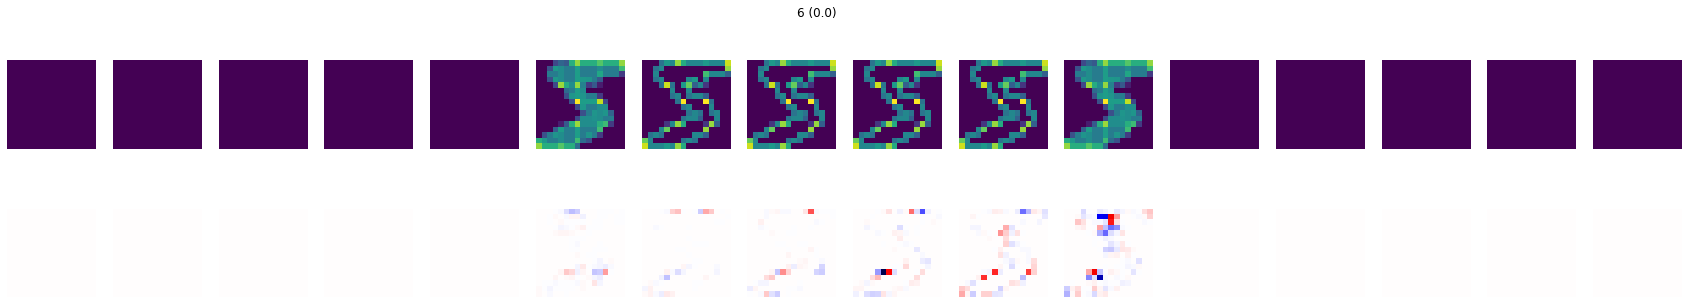

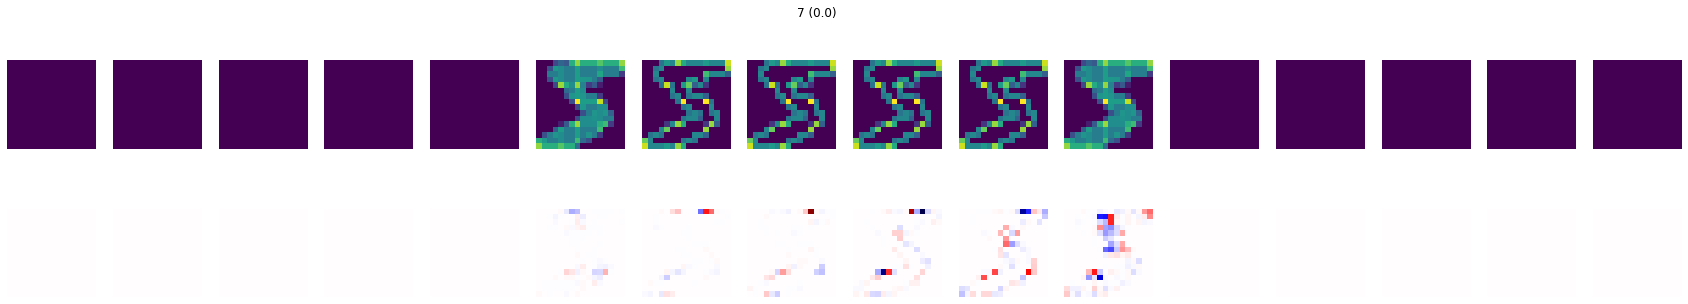

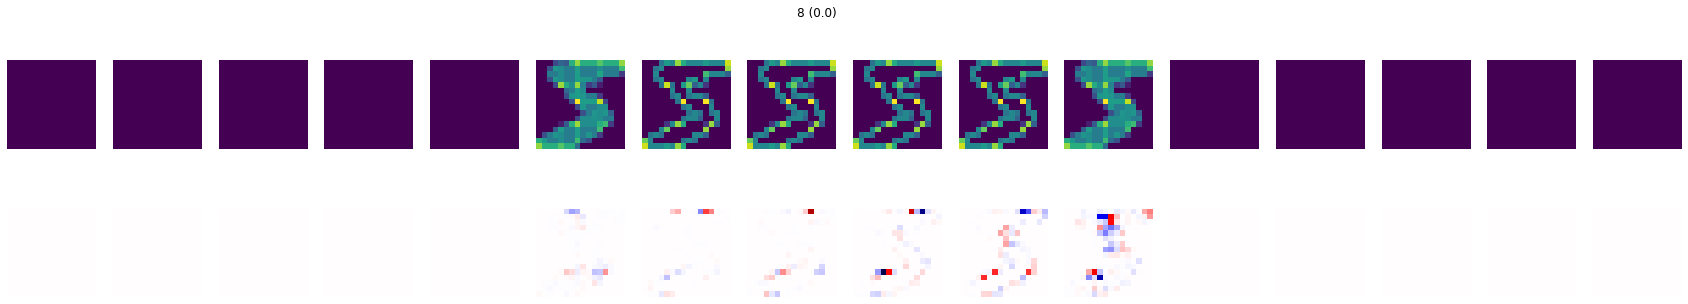

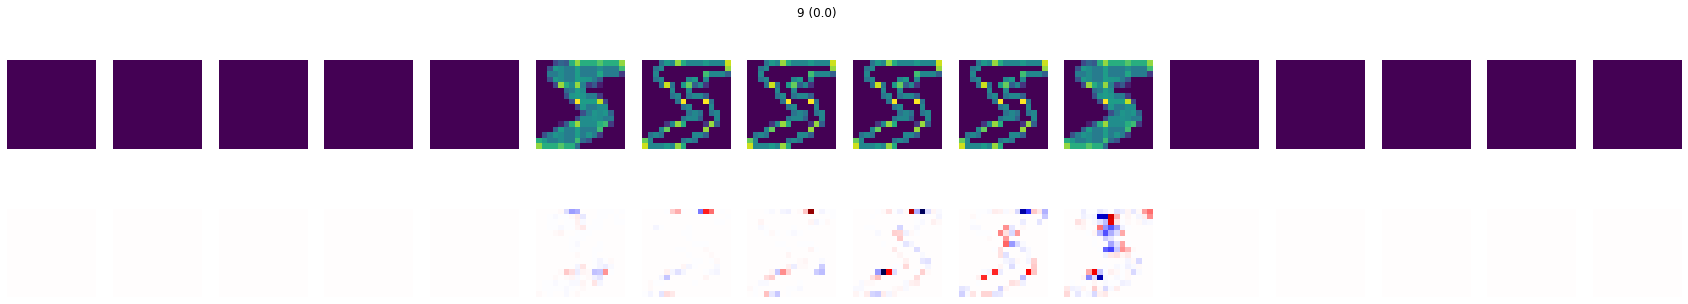

In [14]:
for i in range(len(explanations)):
    explanations[i] = explanations[i] / np.amax(np.abs(explanations[i]))
    explanations[i] -= explanations[i,0,0,0,0]
    
    fig, ax = plt.subplots(2, 16, figsize=(30, 5))
    fig.suptitle(f'{i} ({round(predictions[0,i], 2)})')
    
    for j in range(16):
        ax[0][j].imshow(train_X[image_idx,:,:,j])
        ax[1][j].imshow(explanations[i,:,:,j], cmap='seismic', clim=(-1, 1))
        ax[0][j].axis('off')
        ax[1][j].axis('off')
        
    plt.show()

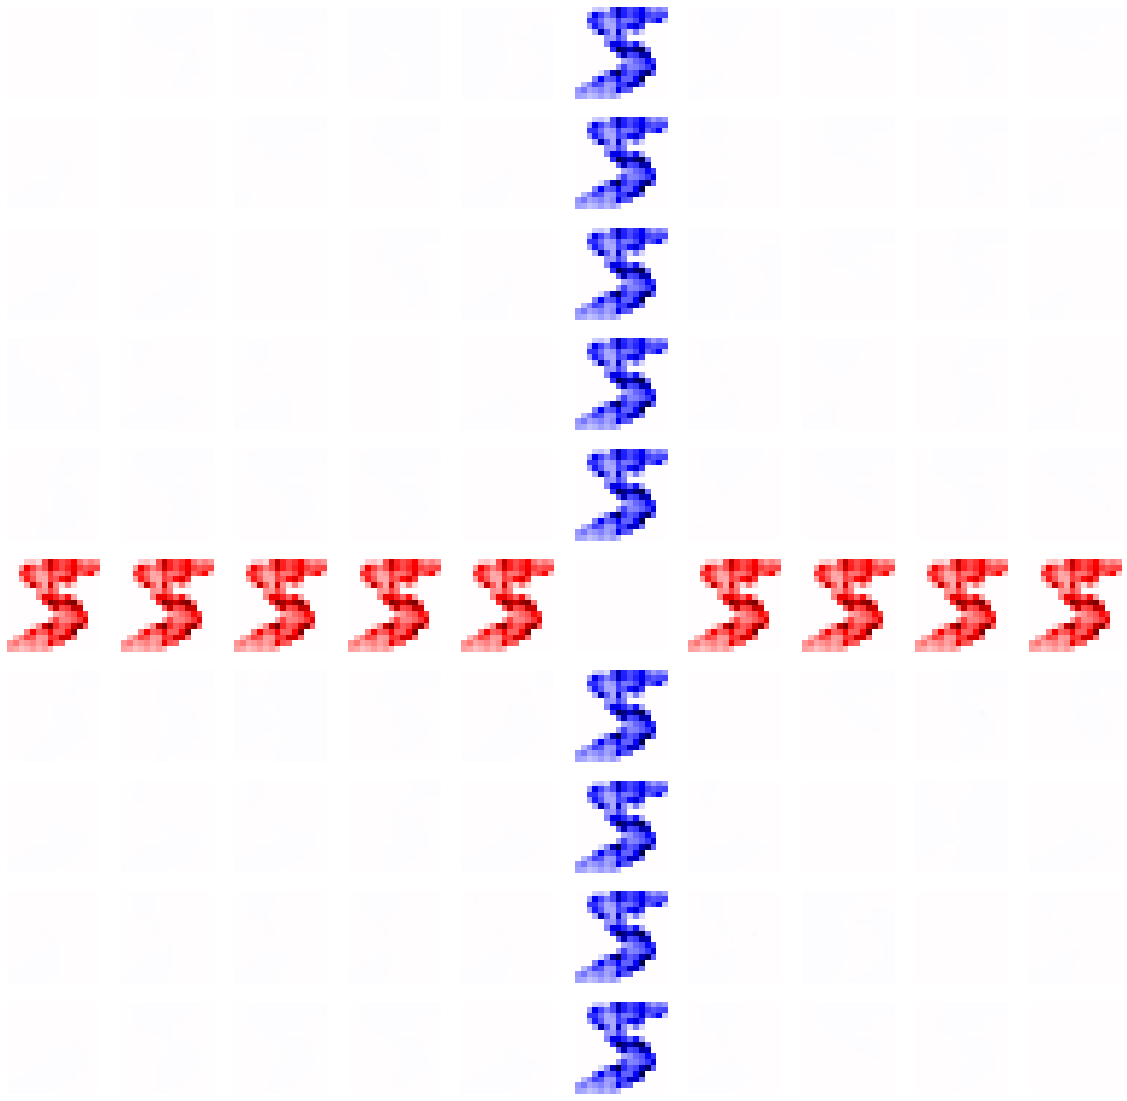

In [11]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))

for i in range(10):
    for j in range(10):
        ax[i][j].axis('off')
        ax[i][j].imshow(explanations[i,:,:,5] - explanations[j,:,:,5], cmap='seismic', clim=(-1, 1))
        
plt.show()